In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
import random
import time

In [2]:
CSM_dir = '/'.join(os.getcwd().split('/')[:-1])
os.chdir(CSM_dir)
sys.path.append(CSM_dir+'/code')

In [3]:
from oligo_design import *

# overview

1) **select sgRNA spacer pairs** - In this example, we will import a CRISPick output file and pair guides targeting the same gene

2) **iBAR pairs** - In this example, we will use one strategy that guarantees edit correction for all individual barcodes.

3) **tRNA selection** (random assignment)

4) **generate oligos**

## select sgRNA spacer pairs

In [4]:
guide_input_df = pd.read_table('input_files/ecdf2fd1-327d-4423-ad71-69247ccfff95-sgrna-designs.txt')
pd.set_option('display.max_columns', 100)

ran out of guides for target  ACTR2
ran out of guides for target  ARHGAP4
ran out of guides for target  CALN1
ran out of guides for target  CLDN25
ran out of guides for target  EWSR1
ran out of guides for target  IST1
ran out of guides for target  MAP9
ran out of guides for target  MRPL45
ran out of guides for target  PLK4
ran out of guides for target  PTGDR
ran out of guides for target  RPL23
ran out of guides for target  TSPAN3
ran out of guides for target  UTP6
ran out of guides for target  VPS28


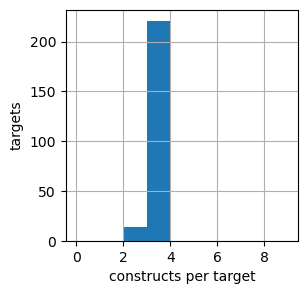

In [6]:
guide_pairs_df = pair_guides_single_target_CRISPick(guide_input_df, constructs_per_gene=3)

plt.figure(figsize=(3,3))
guide_pairs_df.value_counts('target').hist(bins=range(0,10))
plt.xlabel('constructs per target')
plt.ylabel('targets')
plt.show()

# select iBAR sequences

### There are multiple ways to encode information in iBARs. 
iBARs could encode identical sequences in both positions within a construct for simplicity. Or iBARs could be designed for maximum decoding efficiency relying on multiplexed detection. 

### Here, we implement one approach that seeks to balance several performance tradeoffs:

#### 1) all iBARs are unique (iBARs are not repeated in either position)
- the readout of either iBAR alone is sufficient to uniquely identify constructs; the readout of both iBARs is *not* required to uniquely identify constructs
    
#### 2) there is a guaranteed edit distance between all iBARs in a library
- edit distance 2: error detection
- edit distance 3: error correction
   
#### 3) multiplexed detection enables recombination detection
- detection of both iBARs enables detection of all recombination events, with the same per-barcode edit distance guarantees

#### 4) multiplexed detection may enable more efficient decoding
- detection of both iBARs may enable decoding in fewer cycles, but *without* edit distance guarantees
- detection of both iBARs enables detection of most recombination events in 0-1 additional cycles

#### 5) iBAR position is encoded in the first base identity
- reads can be mapped to iBAR position (1 or 2) based on the identity of the first iBAR base
- iBAR1 starts with 'A' or 'G'
- iBAR2 starts with 'C' or 'T'

#### 6) compatibility with clonal barcoding
- as iBAR1 alone is sufficient to identify a construct, iBAR2 may be substituted for a clonal barcode during oligo pool amplification
- degenerate primers for iBAR2 randomization may be designed to maintain iBAR position encoding via first base identity

## pre-computed barcode sets

- barcodes within a set have a guaranteed edit distance of 2 (error detection) or 3 (error correction)

- barcodes are not necessarily compatible across these sets

- these sets were designed with the dna-barcodes repository (https://github.com/feldman4/dna-barcodes) and we recommend this tool for the generation of additional barcode sets

In [7]:
# import all the barcode sets:
df_bc_sets = pd.DataFrame()
search = 'designed_barcode_sets/barcodes_n*_k*_*.noBsmBI.csv'
for file in glob(search):
    df_barcodes = pd.read_csv(file)
    df_bc_sets.loc[file, 'length'] = df_barcodes['n'][0]
    df_bc_sets.loc[file, 'distance'] = df_barcodes['k'][0]
    df_bc_sets.loc[file, 'metric'] = file.split('_')[-1].split('.')[0]
    df_bc_sets.loc[file, 'n_barcodes'] = len(df_barcodes)

df_bc_sets.sort_values('n_barcodes')

,length,distance,metric,n_barcodes
designed_barcode_sets/barcodes_n7_k3_Levenshtein.noBsmBI.csv,7.0,3.0,Levenshtein,230.0
designed_barcode_sets/barcodes_n8_k3_Levenshtein.noBsmBI.csv,8.0,3.0,Levenshtein,835.0
designed_barcode_sets/barcodes_n7_k2_Levenshtein.noBsmBI.csv,7.0,2.0,Levenshtein,1991.0
designed_barcode_sets/barcodes_n9_k3_Levenshtein.noBsmBI.csv,9.0,3.0,Levenshtein,3054.0
designed_barcode_sets/barcodes_n10_k3_Levenshtein.noBsmBI.csv,10.0,3.0,Levenshtein,10644.0
designed_barcode_sets/barcodes_n8_k2_Levenshtein.noBsmBI.csv,8.0,2.0,Levenshtein,12606.0
designed_barcode_sets/barcodes_n9_k2_Levenshtein.noBsmBI.csv,9.0,2.0,Levenshtein,42534.0
designed_barcode_sets/barcodes_n12_k3_Levenshtein.noBsmBI.csv,12.0,3.0,Levenshtein,62679.0
designed_barcode_sets/barcodes_n12_k3_Hamming.noBsmBI.csv,12.0,3.0,Hamming,78784.0
designed_barcode_sets/barcodes_n10_k2_Levenshtein.noBsmBI.csv,10.0,2.0,Levenshtein,178183.0


In [8]:
n_guide_pairs = len(guide_pairs_df)
required_distance = 3 ## 2 for error detection, 3 for error correction

df_bc_sets_subset = df_bc_sets[df_bc_sets['distance']==required_distance]
iBAR_pairs = None

while iBAR_pairs is None:

    selected_bc_file = df_bc_sets_subset[df_bc_sets_subset.n_barcodes > 2*n_guide_pairs].iloc[
        df_bc_sets_subset[df_bc_sets_subset.n_barcodes > 2*n_guide_pairs]['n_barcodes'].argmin()].name 
    
    df_barcodes = pd.read_csv(selected_bc_file)
    
    print('Edit distance %s in %s cycles:\n'%(df_barcodes['k'][0],df_barcodes['n'][0]))
    
    iBAR_pairs = complete_iBARs_v1(df_barcodes, n_guide_pairs)
    
    if iBAR_pairs is None:
        selected_bc_file = selected_bc_file[selected_bc_file.index != selected_bc_file]
        print('\nTrying again with next smallest barcode set.\n')
    if len(selected_bc_file)==0:
        print('ran out of barcode files')

Edit distance 3 in 9 cycles:

generating and filtering complete iBARs


100%|███████████████████████████████████████████████████████████████████████████████████████████| 3054/3054 [00:00<00:00, 6350.99it/s]


optimizing barcode pairing


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.35it/s]


sequencing requirements:
barcode 1 only:
 7 cycles
barcode 2 only:
 7 cycles: 
barcode 1 or 2:
 7 cycles 
barcode 1-2 or 2-1:
 5 cycles with 99% recombination detection
 or:
 6 cycles with 100% recombination detection
barcode 1-2:
 5 cycles with 99% recombination detection
 or:
 6 cycles with 100% recombination detection


In [9]:
library_design_df = guide_pairs_df.merge(iBAR_pairs, left_index=True, right_index=True)
library_design_df

,target,spacer_1,spacer_2,iBAR_1,iBAR_2
0,ACTR2,ACTGGTGTAGTGGTAGACTC,TATAACTAGATATCTTATCA,ATACGGTTACTC,TGATTAGAGGCA
1,ACTR2,AAACAGAGAGAAGATTGTAG,CTTTGATGATACGTCCATCT,GTGGCCGAAGAT,CATTACCTGCAA
2,ACTR3,TAATAGTGGCCAATCCGCCA,AGAACGGACGTTGACCGGTA,GAGTAACTCGCT,CCACATCATTAA
3,ACTR3,ATTAAGGAGTCAGCAAAAGT,AAATGGATTAAACAGTATAC,AACTTGAGTTCA,CTGTCATCCGCG
4,ACTR3,GGAAACTGCTAAGGCAGTAA,GTACAAGCCTGGAACATTGA,AGACTCGTGATA,CCCTACGAGACA
...,...,...,...,...,...
686,ZNF75A,CCACTCAAAAGAGCAGATAC,TCCTTACCCCTCTCATACAC,AAGTGAGATTGA,CAAATTGGGCCA
687,ZNF75A,TCGATCCTAAGAGCTCTTGC,GTTATTGGATCCCACTCAGA,ATCCTCCGGATT,TCAGGGAAACGT
688,ZNHIT3,TCCCCGCTCACTAGGGCACG,CAGGCTGGACAGCGGTATTT,ATTTACGGACTG,CCACCTAACTGC
689,ZNHIT3,GCAGGCTGGACAGCGGTATT,GCACGCGGCAGGCTGGACAG,ACTACTTCAAAC,TATGTGCCGCGC


## select tRNAs at random

In [10]:
library_design_df['tRNA'] = np.random.choice(['tRNA_A','tRNA_P','tRNA_Q'], len(library_design_df))
library_design_df

,target,spacer_1,spacer_2,iBAR_1,iBAR_2,tRNA
0,ACTR2,ACTGGTGTAGTGGTAGACTC,TATAACTAGATATCTTATCA,ATACGGTTACTC,TGATTAGAGGCA,tRNA_P
1,ACTR2,AAACAGAGAGAAGATTGTAG,CTTTGATGATACGTCCATCT,GTGGCCGAAGAT,CATTACCTGCAA,tRNA_P
2,ACTR3,TAATAGTGGCCAATCCGCCA,AGAACGGACGTTGACCGGTA,GAGTAACTCGCT,CCACATCATTAA,tRNA_A
3,ACTR3,ATTAAGGAGTCAGCAAAAGT,AAATGGATTAAACAGTATAC,AACTTGAGTTCA,CTGTCATCCGCG,tRNA_P
4,ACTR3,GGAAACTGCTAAGGCAGTAA,GTACAAGCCTGGAACATTGA,AGACTCGTGATA,CCCTACGAGACA,tRNA_A
...,...,...,...,...,...,...
686,ZNF75A,CCACTCAAAAGAGCAGATAC,TCCTTACCCCTCTCATACAC,AAGTGAGATTGA,CAAATTGGGCCA,tRNA_Q
687,ZNF75A,TCGATCCTAAGAGCTCTTGC,GTTATTGGATCCCACTCAGA,ATCCTCCGGATT,TCAGGGAAACGT,tRNA_A
688,ZNHIT3,TCCCCGCTCACTAGGGCACG,CAGGCTGGACAGCGGTATTT,ATTTACGGACTG,CCACCTAACTGC,tRNA_P
689,ZNHIT3,GCAGGCTGGACAGCGGTATT,GCACGCGGCAGGCTGGACAG,ACTACTTCAAAC,TATGTGCCGCGC,tRNA_Q


## generate oligos

In [11]:
# import dialout primer sequences
df_dialout = pd.read_csv('input_files/kosuri_dialout_primers.csv')
# dialout primers are truncated to 14 nt to keep total oligo length within 300 nt
df_dialout['fwd_short'] = df_dialout['fwd'].str.slice(-14)
df_dialout['rev_short'] = df_dialout['rev'].str.slice(-14)

In [12]:
# here we encode all members under the same dialout primer pair
# sublibraries can be encoded within an order with different dialout primer pairs
library_design_df['dialout']=0

In [13]:
library_design_df['dialout_fwd'] = library_design_df['dialout'].map(df_dialout['fwd_short'])
library_design_df['dialout_rev'] = library_design_df['dialout'].map(df_dialout['rev_short'])
library_design_df

,target,spacer_1,spacer_2,iBAR_1,iBAR_2,tRNA,dialout,dialout_fwd,dialout_rev
0,ACTR2,ACTGGTGTAGTGGTAGACTC,TATAACTAGATATCTTATCA,ATACGGTTACTC,TGATTAGAGGCA,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
1,ACTR2,AAACAGAGAGAAGATTGTAG,CTTTGATGATACGTCCATCT,GTGGCCGAAGAT,CATTACCTGCAA,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
2,ACTR3,TAATAGTGGCCAATCCGCCA,AGAACGGACGTTGACCGGTA,GAGTAACTCGCT,CCACATCATTAA,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
3,ACTR3,ATTAAGGAGTCAGCAAAAGT,AAATGGATTAAACAGTATAC,AACTTGAGTTCA,CTGTCATCCGCG,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
4,ACTR3,GGAAACTGCTAAGGCAGTAA,GTACAAGCCTGGAACATTGA,AGACTCGTGATA,CCCTACGAGACA,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
...,...,...,...,...,...,...,...,...,...
686,ZNF75A,CCACTCAAAAGAGCAGATAC,TCCTTACCCCTCTCATACAC,AAGTGAGATTGA,CAAATTGGGCCA,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
687,ZNF75A,TCGATCCTAAGAGCTCTTGC,GTTATTGGATCCCACTCAGA,ATCCTCCGGATT,TCAGGGAAACGT,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
688,ZNHIT3,TCCCCGCTCACTAGGGCACG,CAGGCTGGACAGCGGTATTT,ATTTACGGACTG,CCACCTAACTGC,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
689,ZNHIT3,GCAGGCTGGACAGCGGTATT,GCACGCGGCAGGCTGGACAG,ACTACTTCAAAC,TATGTGCCGCGC,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA


In [14]:
# build the oligos
oligo_design_df = build_CROPseq_multi_one_step_oligos(library_design_df)
oligo_design_df['oligo_len'] = oligo_design_df['oligo'].str.len()

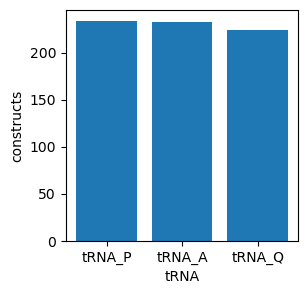

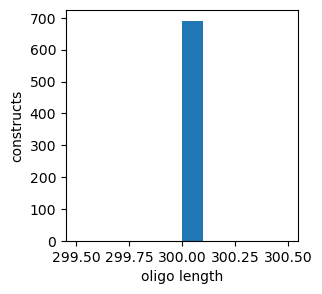

In [15]:
plt.figure(figsize=(3,3))
plt.bar(oligo_design_df.value_counts('tRNA').index, oligo_design_df.value_counts('tRNA').values)
plt.xlabel('tRNA')
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(oligo_design_df.oligo_len)
plt.xlabel('oligo length')
plt.ylabel('constructs')
plt.show()

In [16]:
oligo_design_df.to_csv('oligo_designs/CSM_library_design.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")))
oligo_design_df['oligo'].to_csv('oligo_designs/CSM_oligo_order.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")))